<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction:-Unsupervised-learning-of-filters" data-toc-modified-id="Introduction:-Unsupervised-learning-of-filters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction: Unsupervised learning of filters</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Prepare-an-image-provider-class" data-toc-modified-id="Prepare-an-image-provider-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare an image provider class</a></span></li><li><span><a href="#Define-a-set-of-receptive-fields" data-toc-modified-id="Define-a-set-of-receptive-fields-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define a set of receptive fields</a></span></li></ul></div>

# Introduction: Unsupervised learning of filters

In this notebook we will try to learn a "good" set of filters. However, in contrast to CNNs we will do this in an unsupervised fashion. With a "good" set we will mean, that the filter responses are a helpful input for a classifier that has to learn to classify the images just based on the filter response values.

# Are all libraries that are needed available?

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2

print( "Your NumPy version is: " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is: " + keras.__version__ )
print( "Your OpenCV version is: " + cv2.__version__ )

Using TensorFlow backend.


Your NumPy version is: 1.13.3
Your TensorFlow version is: 1.5.1
Your Keras version is: 2.2.3
Your OpenCV version is: 3.4.1


# Prepare an image provider class

In [66]:
import os
from os import listdir
from os.path import isdir, isfile, join
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder):
        
        self.all_images = []
       
        class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Under folder", root_folder, "I found the following subfolders/classes:")
        print(class_names)
        
        for class_name in class_names:
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name) if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames), subfolder_name) )
            
            for filename in filenames:
                
                self.all_images.append( [filename, class_name] )              
        
        self.nr_images = len(self.all_images)
        print("There are {} images in total available.".format(self.nr_images))
     
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image * (1.0 / 255.0)
        return image
        
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        
        image_filename  = self.all_images[rnd_idx][0]
        image_classname = self.all_images[rnd_idx][1]
        
        image = self.load_image(image_filename)
        
        return image, image_classname
        
        
        
    

Let's test the image provider class:

In [67]:
my_image_provider = image_provider( "data" )

Under folder data I found the following subfolders/classes:
['bikes', 'cars']
1344 files in subfolder data/bikes/
1307 files in subfolder data/cars/
There are 2651 images in total available.


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (375, 500, 3)


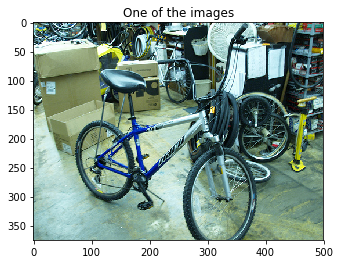

In [68]:
import matplotlib.pyplot as plt

image, label = my_image_provider.get_random_image()
print("image has type", type(image))
print("image has shape", image.shape)
plt.imshow(image)
plt.title("One of the images")
plt.show()

# Define a set of receptive fields

In [121]:
class receptive_fields_random:
    
    #
    # Given some image shape
    # and a desired number of receptive fields
    # to be generated, we will generate
    # the desired number of receptive fields
    # where each receptive field is placed
    # randomly into the image
    #
    def __init__(self, image_shape, nr_of_fields):
        
        img_dimx = image_shape[1]
        img_dimy = image_shape[0]
        
        self.all_fields = []
        
        MIN_RF_SIZE = 15
        
        for field_nr in range(0,nr_of_fields):
            
            rnd_x = np.random.randint(0, img_dimx-MIN_RF_SIZE)
            rnd_y = np.random.randint(0, img_dimy-MIN_RF_SIZE)
            max_size_x = img_dimx-rnd_x-1
            max_size_y = img_dimy-rnd_y-1
            rnd_size = np.random.randint(MIN_RF_SIZE, min(max_size_x,max_size_y))            
            
            next_field = ( rnd_x, rnd_y, rnd_size )
            self.all_fields.append( next_field )
            
    
    #
    # Given the pre-computed set of receptive fields,
    # draw their positions into the specified image
    # by visualizing each receptive field with a rectangle
    #
    def show_fields(self, image):
        
        cpy_image = image.copy()
        
        for field in self.all_fields:
            
            x = field[0]
            y = field[1]
            size = field[2]
            
            cv2.rectangle(cpy_image, (x,y), (x+size,y+size), (1,1,1), 2)
            
        plt.imshow(cpy_image)
        plt.title("Image with receptive field")
        plt.show()
        
        
        
    #
    # Given an image and a specific number of a receptive
    # field, return the corresponding image patch
    #
    def get_single_image_patch(self, image, field_nr):
        
        field = self.all_fields[field_nr]
        
        x = field[0]
        y = field[1]
        size = field[2]
        
        img_patch = image[ y:y+size, x:x+size ]
        return img_patch
        
     
    #
    # Given an image and the pre-computed set of receptive
    # fields, extract for each receptive field the current
    # corresponding image patch,
    # put it into a list of image patches,
    # then return the list
    #
    def get_all_image_patches(self, image):
        
        all_image_patches = []
        
        for field_nr, field in enumerate(self.all_fields):
            
            img_patch = self.get_single_image_patch(image, field_nr)
            
            all_image_patches.append( img_patch )
            
        return all_image_patches
            
            

Let's show the receptive fields:

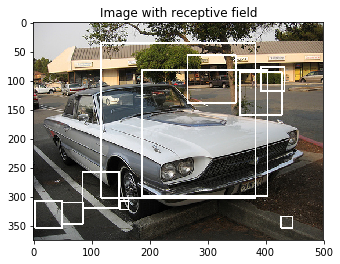

In [124]:
image, label = my_image_provider.get_random_image()
my_receptive_fields = receptive_fields_random(image.shape, 10)
my_receptive_fields.show_fields( image )

Later, we need to extract the image patches from 

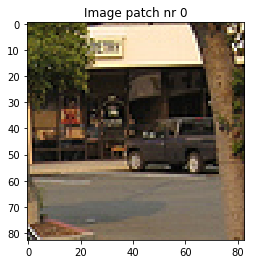

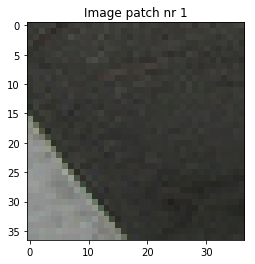

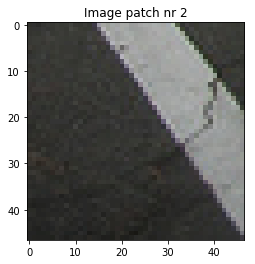

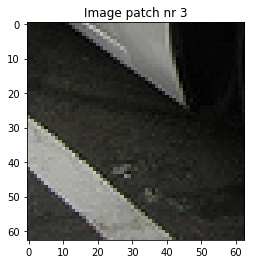

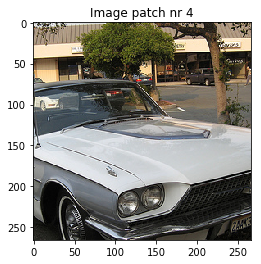

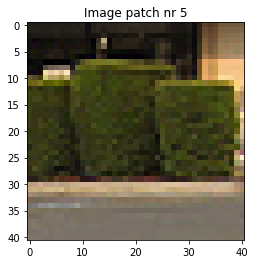

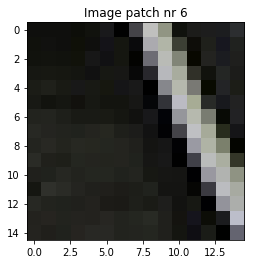

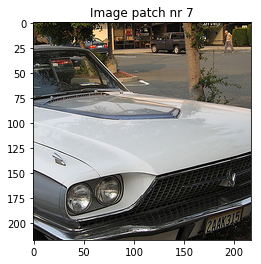

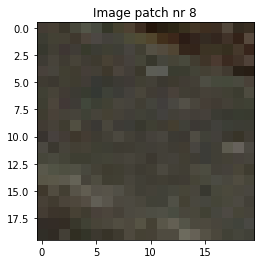

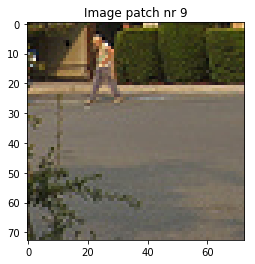

In [125]:
all_img_patches = my_receptive_fields.get_all_image_patches( image )
for img_patch_nr, img_patch in enumerate(all_img_patches):
    plt.imshow(img_patch)
    plt.title( "Image patch nr {}".format(img_patch_nr) )
    plt.show()